The below cell contains all the constants used in rest of the codes

# Constants

In [1]:
"""
Created on Thu Feb 20 08:22:30 2020

@author: Saba
"""
BACK_BONE = 'efficientnetb5'
BATCH_SIZE = 2
Defined_CLASSES = [1]
LR = 0.0001
EPOCHS = 200

NO_TIME_STEPS = 3 #Number of Time_steps
SPLIT_MODE = [0.6, 0.8] #60% Train, (80-60)=20% Val, (100-80)=20% Test


ENCODER_FREEZE = True
MODEL_INPUT_SHAPE = (None,None,3)

In [2]:
import keras
OPTIMIZER = keras.optimizers.Adam(LR)

Using TensorFlow backend.


In [3]:
HOME_DIR = "/home/ubuntu/"

PATH_TO_SAVE_MODEL = HOME_DIR +'/Trained_model/'

MODEL_NAME = "_PRE_LSTM" # _MULTIPLICATION, _CONCAT, _PRE_LSTM, _POST_LSTM, _Nine_W_1_1_CONV, _Nine_WO_1_1_CONV
MODEL_DESC = BACK_BONE+'_batch_'+str(BATCH_SIZE)+'_epoch_'+str(EPOCHS)+'_time_steps_'+str(NO_TIME_STEPS)+MODEL_NAME+'_with_Unet_after'

PATH_TO_INPUT = HOME_DIR + "Dataset/fields_with_masks/"

In [4]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

config =  tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.15.2
Eager execution: False


In [5]:
import matplotlib.pyplot as plt
from io import BytesIO
import matplotlib.image as mpimg
import numpy as np
import cv2
import re

In [6]:
""" This function used to visualize the input, predicted mask and ground truth"""
def visualize(save_status, save_path,flight_code,**images ):
    
    n = len(images)
    plt.figure(figsize=(40,40))
    for i, (name , image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        # plt.title(str(i+1))
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        
    
    if save_status : 
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.savefig(save_path+flight_code+'.jpg')    
    plt.show()
   

In [7]:
def denormalize(x):
    x_max = np.max(x)
    x_min = np.min(x)
    x = (x-x_min) / (x_max - x_min)
    x = x.clip(0,1)
    return x

In [8]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key,reverse=True)   

# Creating Dataset

In [9]:
class Dataset:
    
    CLASSES = Defined_CLASSES
    def __init__(
            self,
            field_dir,
            status, #train,test,validation
            classes = None,
            augmentation = None,
            preprocessing = None
            ):
        """ make a list of image directions  """
        files = ['bounday_mask.png','nutrient_mask.png']
        self.field_dirs = [ids for ids in sorted(os.listdir(field_dir))]
        self.field_fps = [os.path.join(field_dir ,field_id) for field_id in self.field_dirs if len(os.listdir(os.path.join(field_dir ,field_id))) >= NO_TIME_STEPS ]
        
        train, validate, test = np.split(self.field_fps, [int(SPLIT_MODE[0]*len(self.field_fps)), int(SPLIT_MODE[1]*len(self.field_fps))])
        print(len(train))
        print(len(validate))
        print(len(test))
        if status == 'train':
            self.field_fps = train
        elif status == 'validate':
            self.field_fps = validate
        elif status == 'test':
            self.field_fps = test
        
        self.field_codes            = []
        self.field_number            = []
        self.field_images            = []
        self.field_nutrient_mask     = []
        self.field_boundary_mask     = []

        for field_path in self.field_fps:
            flight_dirs = sorted_alphanumeric(os.listdir(field_path))
            codes  = []
            number = []
            images = []
            nutrient_mask = []
            boundary_mask = []

            for j in flight_dirs:
                flight_number, flight_code = j.split('_')
                codes.append(flight_code)
                number.append(flight_number)
                images.append(os.path.join(field_path,j,flight_code+'.png'))
                boundary_mask.append(os.path.join(field_path,j,files[0]))
                nutrient_mask.append(os.path.join(field_path,j,files[1]))


            self.field_codes.append(codes)
            self.field_number.append(number)
            self.field_images.append(images)
            self.field_nutrient_mask.append(nutrient_mask)
            self.field_boundary_mask.append(boundary_mask)

        
        """ set the class values and assign a augmentation and preprocessing method"""
        self.class_values = classes
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self,i):
         
        """ read images"""
        image1 = cv2.imread(self.field_images[i][0])
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        w, h,_ = image1.shape
        
        
        image2 = cv2.imread(self.field_images[i][1])
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
        image2 = cv2.resize(image2, (h,w) , interpolation = cv2.INTER_AREA)
        
        
        image3 = cv2.imread(self.field_images[i][2])
        image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
        image3 = cv2.resize(image3, (h,w), interpolation = cv2.INTER_AREA)
        
        
        boundary_mask = cv2.imread(self.field_boundary_mask[i][0])
        boundary_mask = cv2.cvtColor(boundary_mask, cv2.COLOR_BGR2GRAY)
        
        
        nutrient_mask = cv2.imread(self.field_nutrient_mask[i][0])
        nutrient_mask = cv2.cvtColor(nutrient_mask, cv2.COLOR_BGR2GRAY) 
        
        boundary_mask = denormalize(boundary_mask)
        nutrient_mask = denormalize(nutrient_mask)
        
        """ extract certain classes from mask 1 """
        masks = [(boundary_mask == v) for v in self.class_values]
        boundary_mask = np.stack(masks, axis = -1).astype('float')
        
        boundary_mask_for_slic = np.stack(masks, axis = 0).astype('float')
        
        masks = [(nutrient_mask == v) for v in self.class_values]
        nutrient_mask = np.stack(masks, axis = -1).astype('float')
        
        data1 = {"image": image1,"image2": image2, "image3": image3, "mask": nutrient_mask }
        """ apply augmentation """
        if self.augmentation:
            sample = self.augmentation(**data1)
            image1 , nutrient_mask, image2, image3 = sample['image'], sample['mask'], sample['image2'], sample['image3'] 
         
        data2 = {"image": image1,"image2": image2, "image3": image3, "mask": nutrient_mask }
        """ apply preprocessing """
        if self.preprocessing:
            sample = self.preprocessing(**data2)
            image1 , nutrient_mask,image2,image3 = sample['image'], sample['mask'], sample['image2'],sample['image3']
        
        return image1, image2, image3,nutrient_mask, boundary_mask,self.field_codes[i][0] 
    
    def __len__(self):
        return len(self.field_images)
    

## Dataloader

In [10]:
class Dataloader(keras.utils.Sequence):
    
    def __init__(
            self,
            dataset,
            batch_size = 1,
            shuffle = False
            ):
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        
        self.on_epoch_end()
        
    def __getitem__(self, i):
        
        start = i * self.batch_size
        stop = (i+1) * self.batch_size
        data1 = []
        data2 = []
        data3 = []
        masks = []
        data_concat = []
        data_stack = []
        masks_stack = []
        for j in range(start, stop):
            im1,im2,im3,mask,_,_ = self.dataset[j]
            data1.append(im1)
            data2.append(im2)
            data3.append(im3)
            masks.append(mask)
            
            im1,im2,im3,mask,_,_ = self.dataset[j]
            image_concat = np.concatenate((im1,im2,im3),axis =2)
            data_concat.append((image_concat,mask))
            
            image_stack = np.stack((im3,im2,im1),axis=0)
            #m_stack = np.stack((mask,mask,mask),axis=0)
            m_stack = np.expand_dims(mask,axis = 0)
            data_stack.append(image_stack)
            masks_stack.append(m_stack)
        
        if MODEL_NAME == '_Nine_W_1_1_CONV' or MODEL_NAME == '_Nine_WO_1_1_CONV':
            batch = [np.stack(samples, axis = 0) for samples in zip(*data_concat)]
            return batch
        elif MODEL_NAME == '_PRE_LSTM' or MODEL_NAME == '_POST_LSTM':
            #batch = [np.stack(samples, axis = 0) for samples in zip(*data_stack)]
            return [np.array(data1),np.array(data2),np.array(data3),np.array(data_stack)],[np.array(masks),np.array(masks),np.array(masks),np.array(masks_stack)]
        else:
            return [np.array(data1),np.array(data2),np.array(data3)],[np.array(masks),np.array(masks),np.array(masks)]
    
    def __len__(self):
        """  the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)            

# Do Data Augmentation

In [11]:
import albumentations as A


def round_clip_0_1(x, **kwargs):
    return x.round

def training_augmentation():
        train_transform = [
            A.HorizontalFlip(p = 0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(scale_limit = 0.5, rotate_limit=0, shift_limit = 0.1, p = 1, border_mode=0),
            A.PadIfNeeded(min_height = 512, min_width = 512, always_apply= True, border_mode=0),
            #A.RandomCrop(height=512, width=512, always_apply = True),
            A.CropNonEmptyMaskIfExists(height=512, width=512,always_apply = True),
            #A.RandomResizedCrop(height, width, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1, always_apply=False, p=1.0)
            #A.Resize(height=672, width=672, interpolation=1, always_apply=True, p=1),
            A.IAAAdditiveGaussianNoise(p=0.2),
            A.IAAPerspective(p=0.5),

            A.OneOf(
               [
                   A.CLAHE(p=1),
                   A.RandomBrightness(p=1),
                   A.RandomGamma(p=1),
               ],
               p=0.9,
            ),

            A.OneOf(
               [
                   A.IAASharpen(p=1),
                   A.Blur(blur_limit=3, p=1),
                   A.MotionBlur(blur_limit=3, p=1),
               ],
               p=0.9,
            ),

            A.OneOf(
               [
                   A.RandomContrast(p=1),
                   A.HueSaturationValue(p=1),
               ],
               p=0.9,
           ),
            # A.Lambda(mask = round_clip_0_1)
            #A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, always_apply=False, p=0.5)
        ]
    
        return A.Compose(train_transform,
            additional_targets={"image2" : "image", "image3":"image"})

def validation_augmentation():
    test_transform = [
        A.PadIfNeeded(min_height = 512, min_width = 512, always_apply= True, border_mode=0),
        A.CropNonEmptyMaskIfExists(height=512, width=512, always_apply=True)
        #A.RandomCrop(height=512, width=512, always_apply = True)
        #A.Resize(height=1024, width=1024, interpolation=1, always_apply=True, p=1)
        ]
    return A.Compose(test_transform,additional_targets={"image2" : "image", "image3":"image"})

def get_preprocessing(preprocessing_fn):
    
    _transform = [
        A.Lambda(image = preprocessing_fn),
        ]
    return A.Compose(_transform,additional_targets={"image2" : "image", "image3":"image"})

# Model Settings

In [12]:
import segmentation_models as sm
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, Concatenate, Multiply, Reshape
from keras.layers import BatchNormalization, ConvLSTM2D, Conv3D,Lambda
import keras.backend as K

""" define preprocess method condisering back_bone"""
preprocess_input = sm.get_preprocessing(BACK_BONE)
""" model parameters"""
n_classes = 1 if len(Defined_CLASSES)== 1 else (len(Defined_CLASSES)+1)
activation = 'sigmoid' if n_classes == 1 else 'softmax'

  

Segmentation Models: using `keras` framework.


In [13]:
"""creating a model"""

class MyModels():
    def _Nine_WO_1_1_CONV(self):
        final_model = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape=(None,None,9), encoder_weights=None,encoder_freeze = ENCODER_FREEZE)
        return final_model
    def _Nine_W_1_1_CONV(self):
        model = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        
        model.layers.pop(0)
        newInputs = Input(shape=(None,None,9))
        x = Conv2D(3, kernel_size=(1,1))(newInputs)
        newOutputs = model(x)
        final_model = Model(newInputs, newOutputs)
        
        return final_model
        
    def _MULTIPLICATION(self):
        model_1 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        model_2 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        model_3 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        
        input_1 = Input(shape=(512,512,3), name='input_1')
        input_2 = Input(shape=(512,512,3), name='input_2')
        input_3 = Input(shape=(512,512,3), name='input_3')

        x3 = Model(model_1.input, model_1.output, name='model_3')(input_3)
        p = Concatenate(axis=3)([x3,x3,x3])

        input_2_new =Multiply()([input_2, p])

        x2 = Model(model_2.input, model_2.output, name='model_2')(input_2_new)
        p = Concatenate(axis=3)([x2,x2,x2])

        input_1_new =Multiply()([input_1, p])

        x1 = Model(model_3.input, model_3.output , name='model_1')(input_1_new)

        final_model = Model(inputs =[input_1,input_2,input_3],outputs=[x3,x2,x1])

        return final_model
    
    def _CONCAT(self):
        model_1 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        inp = Input(shape=(None, None, 4))
        l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
        out = model_1(l1)
        model_1 = Model(inp, out, name=model_1.name)
        model_2 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        inp = Input(shape=(None, None, 4))
        l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
        out = model_2(l1)
        model_2 = Model(inp, out, name=model_2.name)
        
        model_3 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        inp = Input(shape=(None, None, 4))
        l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
        out = model_3(l1)
        model_3 = keras.models.Model(inp, out, name=model_3.name)
        
        input_1 = Input(shape=(512,512,3), name='input_1')
        input_2 = Input(shape=(512,512,3), name='input_2')
        input_3 = Input(shape=(512,512,3), name='input_3')

        x3 = Model(model_1.input, model_1.output, name='model_3')(input_3)
        
        input_2_new =Concatenate(axis=3)([x3, input_2])
        x2 = Model(model_2.input, model_2.output, name='model_2')(input_2_new)

        input_1_new =Concatenate(axis=3)([x2, input_1])
        x1 = Model(model_3.input, model_3.output , name='model_1')(input_1_new)

        final_model = Model(inputs =[input_1,input_2,input_3],outputs=[x3,x2,x1])

        return final_model
    def _PRE_LSTM(self):
        model_1 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        model_2 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        model_3 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        
        input_1 = Input(shape=(512,512,3), name='input_1')
        input_2 = Input(shape=(512,512,3), name='input_2')
        input_3 = Input(shape=(512,512,3), name='input_3')
        
        combine_input = Input(shape=(3,512,512,3), name='combine_input')        

        x = ConvLSTM2D(filters=4, kernel_size=(3, 3),data_format='channels_last', padding="same", return_sequences=True)(combine_input)
        x = BatchNormalization()(x)
        x = ConvLSTM2D(filters=4, kernel_size=(3, 3),data_format='channels_last', padding="same", return_sequences=True)(x)
        x = BatchNormalization()(x)
        x = ConvLSTM2D(filters=4, kernel_size=(3, 3),data_format='channels_last', padding="same", return_sequences=True)(x)
        x = BatchNormalization()(x)
        x = ConvLSTM2D(filters=4, kernel_size=(3, 3),data_format='channels_last', padding="same", return_sequences=True)(x)
        x = BatchNormalization()(x)
        x = Conv3D( filters=1, kernel_size=(3, 3, 3),data_format='channels_last', activation="sigmoid", padding="same", name = 'output')(x)

        x3 = Lambda( lambda x: tf.slice(x, (0,0, 0, 0,0), (-1,1,-1, -1, -1)))(x)
        x3 = Reshape((512,512,1))(x3)
        
        x2 = Lambda( lambda x: tf.slice(x, (0,1, 0, 0,0), (-1,1,-1, -1, -1)))(x)
        x2 = Reshape((512,512,1))(x2)
        
        x1 = Lambda( lambda x: tf.slice(x, (0,2, 0, 0,0), (-1,1,-1, -1, -1)))(x)
        x1 = Reshape((512,512,1))(x1)


        input_3_new =Concatenate(axis=3)([x3, input_3])
        input_3_new = Conv2D(3, (1, 1))(input_3_new)
        x3 = Model(model_1.input, model_1.output, name='model_3')(input_3_new)
        
        input_2_new =Concatenate(axis=3)([x2, input_2])
        input_2_new = Conv2D(3, (1, 1))(input_2_new)
        x2 = Model(model_2.input, model_2.output, name='model_2')(input_2_new)
        
        input_1_new =Concatenate(axis=3)([x1, input_1])
        input_1_new = Conv2D(3, (1, 1))(input_1_new)
        x1 = Model(model_3.input, model_3.output , name='model_1')(input_1_new)
        
        final_model = Model(inputs=[input_1,input_2,input_3,combine_input],outputs=[x3,x2,x1,x])

        return final_model
    
    def _POST_LSTM(self):
        model_1 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        model_2 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        model_3 = sm.Unet(BACK_BONE, classes = n_classes, activation = activation,input_shape = MODEL_INPUT_SHAPE, encoder_weights='imagenet',encoder_freeze = ENCODER_FREEZE)
        
        input_1 = Input(shape=(512,512,3), name='input_1')
        input_2 = Input(shape=(512,512,3), name='input_2')
        input_3 = Input(shape=(512,512,3), name='input_3')

        x3 = Model(model_1.input, model_1.output, name='model_3')(input_3)

        x2 = Model(model_2.input, model_2.output, name='model_2')(input_2)
        
        x1 = Model(model_3.input, model_3.output , name='model_1')(input_1)
        
        new_input = stack((x3,x2,x1), axis=1)
        
        x = ConvLSTM2D(filters=40, kernel_size=(3, 3),data_format='channels_last', padding="same", return_sequences=True)(new_input)
        x = BatchNormalization()(x)
        x = ConvLSTM2D(filters=40, kernel_size=(3, 3),data_format='channels_last', padding="same", return_sequences=True)(x)
        x = BatchNormalization()(x)
        x = ConvLSTM2D(filters=40, kernel_size=(3, 3),data_format='channels_last', padding="same", return_sequences=True)(x)
        x = BatchNormalization()(x)
        x = ConvLSTM2D(filters=40, kernel_size=(3, 3),data_format='channels_last', padding="same", return_sequences=True)(x)
        x = BatchNormalization()(x)
        x = Conv3D( filters=1, kernel_size=(3, 3, 3),data_format='channels_last', activation="sigmoid", padding="same", name = 'output')(x)

        final_model = Model(inputs =[input_1,input_2,input_3],outputs=[x3,x2,x1])

        return final_model
    

In [14]:
my_cls = MyModels()
model = getattr(my_cls, MODEL_NAME)()
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
combine_input (InputLayer)      (None, 3, 512, 512,  0                                            
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 3, 512, 512,  1024        combine_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 3, 512, 512,  16          conv_lst_m2d_1[0][0]             
__________________________________________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)     (None, 3, 512, 512,  1168        batch_normaliza

In [15]:
""" defining loss function and metrics"""
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.1,0.3,0.7,0.9])) 
#focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)
total_loss = sm.losses.binary_focal_dice_loss
losses = {
    "model_3": total_loss,
    "model_2": total_loss,
    "model_1": total_loss,
    "output": total_loss
}
metrics = [sm.metrics.IOUScore(threshold =0.5), sm.metrics.FScore(threshold = 0.5), sm.metrics.Precision(threshold = 0.5),sm.metrics.Recall(threshold = 0.5) ]

""" compiling the network """
model.compile(OPTIMIZER, losses, metrics)

In [16]:
""" loading traind and validation dataset """
train_dataset = Dataset(PATH_TO_INPUT,
                        status = 'train',
                           classes = Defined_CLASSES,
                           augmentation = training_augmentation(),
                           preprocessing = get_preprocessing(preprocess_input),
                           )

valid_dataset = Dataset(PATH_TO_INPUT,
                        status = 'validate',
                           classes = Defined_CLASSES,
                           augmentation = training_augmentation(),
                           preprocessing = get_preprocessing(preprocess_input),
                           )

train_dataloader = Dataloader(train_dataset, batch_size = BATCH_SIZE, shuffle = True )
valid_dataloader = Dataloader(valid_dataset, batch_size = 1, shuffle = False )

231
77
78
231
77
78


## Train the MODEL

In [17]:
""" define callbacks  for learning rate scheduling and best checkpoints """

callbacks = [
    keras.callbacks.ModelCheckpoint(PATH_TO_SAVE_MODEL+MODEL_DESC+'.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    ]

history = model.fit_generator(
    train_dataloader,
    steps_per_epoch = len(train_dataloader),
    epochs = EPOCHS,
    callbacks = callbacks,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
    )


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
  3/115 [..............................] - ETA: 3:06:44 - loss: 3.4306 - model_3_loss: 0.8870 - model_2_loss: 0.8460 - model_1_loss: 0.8534 - output_loss: 0.8442 - model_3_iou_score: 0.2339 - model_3_f1-score: 0.3764 - model_3_precision: 0.2652 - model_3_recall: 0.6621 - model_2_iou_score: 0.1179 - model_2_f1-score: 0.2098 - model_2_precision: 0.1935 - model_2_recall: 0.2320 - model_1_iou_score: 0.1554 - model_1_f1-score: 0.2679 - model_1_precision: 0.2222 - model_1_recall: 0.3428 - output_iou_score: 0.2529 - output_f1-score: 0.4945 - output_precision: 0.2958 - output_recall: 2.1545

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


115/115 [==============================] - 438s 4s/step - loss: 3.9735 - model_3_loss: 1.0121 - model_2_loss: 0.9456 - model_1_loss: 0.9460 - output_loss: 1.0699 - model_3_iou_score: 0.0815 - model_3_f1-score: 0.1444 - model_3_precision: 0.1046 - model_3_recall: 0.4472 - model_2_iou_score: 0.0746 - model_2_f1-score: 0.1338 - model_2_precision: 0.1240 - model_2_recall: 0.2333 - model_1_iou_score: 0.1217 - model_1_f1-score: 0.2052 - model_1_precision: 0.1662 - model_1_recall: 0.4480 - output_iou_score: 0.0823 - output_f1-score: 0.1643 - output_precision: 0.0951 - output_recall: 1.6263 - val_loss: 4.3545 - val_model_3_loss: 1.2663 - val_model_2_loss: 0.9591 - val_model_1_loss: 1.0027 - val_output_loss: 1.1263 - val_model_3_iou_score: 0.0633 - val_model_3_f1-score: 0.1098 - val_model_3_precision: 0.0743 - val_model_3_recall: 0.7076 - val_model_2_iou_score: 0.0798 - val_model_2_f1-score: 0.1378 - val_model_2_precision: 0.1450 - val_model_2_recall: 0.4116 - val_model_1_iou_score: 0.1006 - va

Epoch 8/200
115/115 [==============================] - 111s 964ms/step - loss: 3.3417 - model_3_loss: 0.8376 - model_2_loss: 0.8288 - model_1_loss: 0.7405 - output_loss: 0.9348 - model_3_iou_score: 0.1794 - model_3_f1-score: 0.2872 - model_3_precision: 0.2989 - model_3_recall: 0.4150 - model_2_iou_score: 0.1798 - model_2_f1-score: 0.2893 - model_2_precision: 0.3076 - model_2_recall: 0.4032 - model_1_iou_score: 0.2546 - model_1_f1-score: 0.3847 - model_1_precision: 0.4120 - model_1_recall: 0.5083 - output_iou_score: 0.0589 - output_f1-score: 0.1630 - output_precision: 0.1336 - output_recall: 0.6957 - val_loss: 3.6078 - val_model_3_loss: 0.9042 - val_model_2_loss: 0.9011 - val_model_1_loss: 0.8313 - val_output_loss: 0.9712 - val_model_3_iou_score: 0.1222 - val_model_3_f1-score: 0.1902 - val_model_3_precision: 0.2516 - val_model_3_recall: 0.3867 - val_model_2_iou_score: 0.1352 - val_model_2_f1-score: 0.2098 - val_model_2_precision: 0.2924 - val_model_2_recall: 0.4003 - val_model_1_iou_sco

Epoch 15/200
115/115 [==============================] - 110s 957ms/step - loss: 3.2560 - model_3_loss: 0.8249 - model_2_loss: 0.8164 - model_1_loss: 0.7087 - output_loss: 0.9060 - model_3_iou_score: 0.1769 - model_3_f1-score: 0.2845 - model_3_precision: 0.2922 - model_3_recall: 0.4113 - model_2_iou_score: 0.1765 - model_2_f1-score: 0.2855 - model_2_precision: 0.3054 - model_2_recall: 0.3965 - model_1_iou_score: 0.2642 - model_1_f1-score: 0.3983 - model_1_precision: 0.4274 - model_1_recall: 0.5235 - output_iou_score: 0.1046 - output_f1-score: 0.1802 - output_precision: 0.3703 - output_recall: 0.3949 - val_loss: 3.5465 - val_model_3_loss: 0.9016 - val_model_2_loss: 0.9030 - val_model_1_loss: 0.7976 - val_output_loss: 0.9443 - val_model_3_iou_score: 0.1192 - val_model_3_f1-score: 0.1894 - val_model_3_precision: 0.2234 - val_model_3_recall: 0.3902 - val_model_2_iou_score: 0.1064 - val_model_2_f1-score: 0.1752 - val_model_2_precision: 0.2768 - val_model_2_recall: 0.3079 - val_model_1_iou_sc

Epoch 22/200
115/115 [==============================] - 112s 971ms/step - loss: 3.2435 - model_3_loss: 0.8272 - model_2_loss: 0.8132 - model_1_loss: 0.7110 - output_loss: 0.8922 - model_3_iou_score: 0.1724 - model_3_f1-score: 0.2771 - model_3_precision: 0.2958 - model_3_recall: 0.3768 - model_2_iou_score: 0.1829 - model_2_f1-score: 0.2928 - model_2_precision: 0.3100 - model_2_recall: 0.3929 - model_1_iou_score: 0.2643 - model_1_f1-score: 0.3976 - model_1_precision: 0.4261 - model_1_recall: 0.5069 - output_iou_score: 0.1279 - output_f1-score: 0.1933 - output_precision: 0.4331 - output_recall: 0.3920 - val_loss: 3.5719 - val_model_3_loss: 0.9250 - val_model_2_loss: 0.8700 - val_model_1_loss: 0.8483 - val_output_loss: 0.9285 - val_model_3_iou_score: 0.0886 - val_model_3_f1-score: 0.1356 - val_model_3_precision: 0.3965 - val_model_3_recall: 0.1252 - val_model_2_iou_score: 0.1448 - val_model_2_f1-score: 0.2262 - val_model_2_precision: 0.3034 - val_model_2_recall: 0.3293 - val_model_1_iou_sc

Epoch 29/200
115/115 [==============================] - 112s 976ms/step - loss: 3.1540 - model_3_loss: 0.8000 - model_2_loss: 0.7877 - model_1_loss: 0.6770 - output_loss: 0.8893 - model_3_iou_score: 0.1974 - model_3_f1-score: 0.3123 - model_3_precision: 0.3335 - model_3_recall: 0.4390 - model_2_iou_score: 0.2055 - model_2_f1-score: 0.3236 - model_2_precision: 0.3445 - model_2_recall: 0.4497 - model_1_iou_score: 0.2874 - model_1_f1-score: 0.4283 - model_1_precision: 0.4637 - model_1_recall: 0.5408 - output_iou_score: 0.1521 - output_f1-score: 0.2375 - output_precision: 0.4746 - output_recall: 0.4271 - val_loss: 3.4906 - val_model_3_loss: 0.8917 - val_model_2_loss: 0.8796 - val_model_1_loss: 0.7972 - val_output_loss: 0.9222 - val_model_3_iou_score: 0.1271 - val_model_3_f1-score: 0.1983 - val_model_3_precision: 0.2848 - val_model_3_recall: 0.2949 - val_model_2_iou_score: 0.1431 - val_model_2_f1-score: 0.2213 - val_model_2_precision: 0.2831 - val_model_2_recall: 0.4114 - val_model_1_iou_sc

Epoch 36/200
115/115 [==============================] - 110s 960ms/step - loss: 3.2279 - model_3_loss: 0.8196 - model_2_loss: 0.8145 - model_1_loss: 0.7169 - output_loss: 0.8769 - model_3_iou_score: 0.1766 - model_3_f1-score: 0.2830 - model_3_precision: 0.3195 - model_3_recall: 0.3889 - model_2_iou_score: 0.1830 - model_2_f1-score: 0.2944 - model_2_precision: 0.3352 - model_2_recall: 0.4043 - model_1_iou_score: 0.2589 - model_1_f1-score: 0.3924 - model_1_precision: 0.4487 - model_1_recall: 0.4966 - output_iou_score: 0.1355 - output_f1-score: 0.2165 - output_precision: 0.4905 - output_recall: 0.3929 - val_loss: 3.5038 - val_model_3_loss: 0.9018 - val_model_2_loss: 0.8870 - val_model_1_loss: 0.7893 - val_output_loss: 0.9257 - val_model_3_iou_score: 0.1197 - val_model_3_f1-score: 0.1850 - val_model_3_precision: 0.2881 - val_model_3_recall: 0.3425 - val_model_2_iou_score: 0.1599 - val_model_2_f1-score: 0.2361 - val_model_2_precision: 0.3234 - val_model_2_recall: 0.3438 - val_model_1_iou_sc

Epoch 43/200
115/115 [==============================] - 111s 965ms/step - loss: 3.1580 - model_3_loss: 0.8102 - model_2_loss: 0.7967 - model_1_loss: 0.6762 - output_loss: 0.8749 - model_3_iou_score: 0.1839 - model_3_f1-score: 0.2950 - model_3_precision: 0.3153 - model_3_recall: 0.4160 - model_2_iou_score: 0.1939 - model_2_f1-score: 0.3098 - model_2_precision: 0.3428 - model_2_recall: 0.4221 - model_1_iou_score: 0.2889 - model_1_f1-score: 0.4309 - model_1_precision: 0.4755 - model_1_recall: 0.5286 - output_iou_score: 0.1275 - output_f1-score: 0.2261 - output_precision: 0.4302 - output_recall: 0.4232 - val_loss: 3.4901 - val_model_3_loss: 0.8996 - val_model_2_loss: 0.8741 - val_model_1_loss: 0.7863 - val_output_loss: 0.9302 - val_model_3_iou_score: 0.1176 - val_model_3_f1-score: 0.1833 - val_model_3_precision: 0.2803 - val_model_3_recall: 0.2999 - val_model_2_iou_score: 0.1395 - val_model_2_f1-score: 0.2178 - val_model_2_precision: 0.3373 - val_model_2_recall: 0.3590 - val_model_1_iou_sc

Epoch 50/200
115/115 [==============================] - 111s 964ms/step - loss: 3.1334 - model_3_loss: 0.8015 - model_2_loss: 0.7796 - model_1_loss: 0.6694 - output_loss: 0.8829 - model_3_iou_score: 0.1955 - model_3_f1-score: 0.3091 - model_3_precision: 0.3305 - model_3_recall: 0.4142 - model_2_iou_score: 0.2108 - model_2_f1-score: 0.3325 - model_2_precision: 0.3530 - model_2_recall: 0.4385 - model_1_iou_score: 0.2956 - model_1_f1-score: 0.4374 - model_1_precision: 0.4888 - model_1_recall: 0.5084 - output_iou_score: 0.1559 - output_f1-score: 0.2513 - output_precision: 0.4494 - output_recall: 0.4422 - val_loss: 3.4811 - val_model_3_loss: 0.8818 - val_model_2_loss: 0.8944 - val_model_1_loss: 0.7874 - val_output_loss: 0.9175 - val_model_3_iou_score: 0.1257 - val_model_3_f1-score: 0.1958 - val_model_3_precision: 0.2877 - val_model_3_recall: 0.3169 - val_model_2_iou_score: 0.1188 - val_model_2_f1-score: 0.1911 - val_model_2_precision: 0.3117 - val_model_2_recall: 0.3384 - val_model_1_iou_sc

Epoch 57/200
115/115 [==============================] - 111s 965ms/step - loss: 3.1419 - model_3_loss: 0.8031 - model_2_loss: 0.7857 - model_1_loss: 0.6750 - output_loss: 0.8781 - model_3_iou_score: 0.1896 - model_3_f1-score: 0.2994 - model_3_precision: 0.3140 - model_3_recall: 0.4265 - model_2_iou_score: 0.1990 - model_2_f1-score: 0.3156 - model_2_precision: 0.3385 - model_2_recall: 0.4188 - model_1_iou_score: 0.2867 - model_1_f1-score: 0.4239 - model_1_precision: 0.4639 - model_1_recall: 0.5249 - output_iou_score: 0.1549 - output_f1-score: 0.2428 - output_precision: 0.4675 - output_recall: 0.4375 - val_loss: 3.4609 - val_model_3_loss: 0.8923 - val_model_2_loss: 0.8745 - val_model_1_loss: 0.7712 - val_output_loss: 0.9230 - val_model_3_iou_score: 0.1259 - val_model_3_f1-score: 0.1930 - val_model_3_precision: 0.2795 - val_model_3_recall: 0.2800 - val_model_2_iou_score: 0.1360 - val_model_2_f1-score: 0.2061 - val_model_2_precision: 0.3465 - val_model_2_recall: 0.2746 - val_model_1_iou_sc

Epoch 64/200
115/115 [==============================] - 111s 963ms/step - loss: 3.1145 - model_3_loss: 0.7864 - model_2_loss: 0.7751 - model_1_loss: 0.6670 - output_loss: 0.8860 - model_3_iou_score: 0.2049 - model_3_f1-score: 0.3237 - model_3_precision: 0.3548 - model_3_recall: 0.4320 - model_2_iou_score: 0.2110 - model_2_f1-score: 0.3334 - model_2_precision: 0.3718 - model_2_recall: 0.4331 - model_1_iou_score: 0.2991 - model_1_f1-score: 0.4400 - model_1_precision: 0.4932 - model_1_recall: 0.5286 - output_iou_score: 0.1386 - output_f1-score: 0.2260 - output_precision: 0.4205 - output_recall: 0.4196 - val_loss: 3.4885 - val_model_3_loss: 0.8962 - val_model_2_loss: 0.8799 - val_model_1_loss: 0.7795 - val_output_loss: 0.9330 - val_model_3_iou_score: 0.1196 - val_model_3_f1-score: 0.1846 - val_model_3_precision: 0.2614 - val_model_3_recall: 0.2915 - val_model_2_iou_score: 0.1374 - val_model_2_f1-score: 0.2129 - val_model_2_precision: 0.3250 - val_model_2_recall: 0.3576 - val_model_1_iou_sc

Epoch 71/200
115/115 [==============================] - 111s 964ms/step - loss: 3.1467 - model_3_loss: 0.8049 - model_2_loss: 0.7878 - model_1_loss: 0.6737 - output_loss: 0.8804 - model_3_iou_score: 0.1906 - model_3_f1-score: 0.3022 - model_3_precision: 0.3365 - model_3_recall: 0.4124 - model_2_iou_score: 0.2086 - model_2_f1-score: 0.3267 - model_2_precision: 0.3614 - model_2_recall: 0.4337 - model_1_iou_score: 0.2943 - model_1_f1-score: 0.4334 - model_1_precision: 0.4990 - model_1_recall: 0.5129 - output_iou_score: 0.1341 - output_f1-score: 0.2199 - output_precision: 0.4284 - output_recall: 0.3972 - val_loss: 3.4994 - val_model_3_loss: 0.8858 - val_model_2_loss: 0.8762 - val_model_1_loss: 0.8055 - val_output_loss: 0.9317 - val_model_3_iou_score: 0.1275 - val_model_3_f1-score: 0.1941 - val_model_3_precision: 0.2473 - val_model_3_recall: 0.2922 - val_model_2_iou_score: 0.1283 - val_model_2_f1-score: 0.2024 - val_model_2_precision: 0.2777 - val_model_2_recall: 0.3070 - val_model_1_iou_sc

Epoch 78/200
115/115 [==============================] - 111s 964ms/step - loss: 3.1404 - model_3_loss: 0.7991 - model_2_loss: 0.7858 - model_1_loss: 0.6777 - output_loss: 0.8777 - model_3_iou_score: 0.1979 - model_3_f1-score: 0.3101 - model_3_precision: 0.3238 - model_3_recall: 0.4429 - model_2_iou_score: 0.2075 - model_2_f1-score: 0.3255 - model_2_precision: 0.3458 - model_2_recall: 0.4442 - model_1_iou_score: 0.2891 - model_1_f1-score: 0.4286 - model_1_precision: 0.4708 - model_1_recall: 0.5423 - output_iou_score: 0.1518 - output_f1-score: 0.2453 - output_precision: 0.4553 - output_recall: 0.4273 - val_loss: 3.4428 - val_model_3_loss: 0.8794 - val_model_2_loss: 0.8705 - val_model_1_loss: 0.7614 - val_output_loss: 0.9316 - val_model_3_iou_score: 0.1358 - val_model_3_f1-score: 0.2053 - val_model_3_precision: 0.3044 - val_model_3_recall: 0.2917 - val_model_2_iou_score: 0.1493 - val_model_2_f1-score: 0.2237 - val_model_2_precision: 0.3109 - val_model_2_recall: 0.3474 - val_model_1_iou_sc

Epoch 85/200
115/115 [==============================] - 112s 974ms/step - loss: 3.1350 - model_3_loss: 0.8031 - model_2_loss: 0.7812 - model_1_loss: 0.6796 - output_loss: 0.8711 - model_3_iou_score: 0.1956 - model_3_f1-score: 0.3093 - model_3_precision: 0.3355 - model_3_recall: 0.4179 - model_2_iou_score: 0.2145 - model_2_f1-score: 0.3382 - model_2_precision: 0.3585 - model_2_recall: 0.4524 - model_1_iou_score: 0.2895 - model_1_f1-score: 0.4307 - model_1_precision: 0.4831 - model_1_recall: 0.5175 - output_iou_score: 0.1384 - output_f1-score: 0.2360 - output_precision: 0.4379 - output_recall: 0.4129 - val_loss: 3.4852 - val_model_3_loss: 0.8849 - val_model_2_loss: 0.8878 - val_model_1_loss: 0.7779 - val_output_loss: 0.9346 - val_model_3_iou_score: 0.1423 - val_model_3_f1-score: 0.2159 - val_model_3_precision: 0.2915 - val_model_3_recall: 0.3161 - val_model_2_iou_score: 0.1316 - val_model_2_f1-score: 0.2093 - val_model_2_precision: 0.3271 - val_model_2_recall: 0.3680 - val_model_1_iou_sc

Epoch 92/200
115/115 [==============================] - 114s 989ms/step - loss: 3.1977 - model_3_loss: 0.8184 - model_2_loss: 0.8073 - model_1_loss: 0.6850 - output_loss: 0.8869 - model_3_iou_score: 0.1778 - model_3_f1-score: 0.2860 - model_3_precision: 0.3035 - model_3_recall: 0.4157 - model_2_iou_score: 0.1868 - model_2_f1-score: 0.2994 - model_2_precision: 0.3183 - model_2_recall: 0.4133 - model_1_iou_score: 0.2792 - model_1_f1-score: 0.4178 - model_1_precision: 0.4515 - model_1_recall: 0.5198 - output_iou_score: 0.1490 - output_f1-score: 0.2371 - output_precision: 0.4556 - output_recall: 0.4164 - val_loss: 3.4444 - val_model_3_loss: 0.8841 - val_model_2_loss: 0.8611 - val_model_1_loss: 0.7758 - val_output_loss: 0.9234 - val_model_3_iou_score: 0.1136 - val_model_3_f1-score: 0.1810 - val_model_3_precision: 0.3193 - val_model_3_recall: 0.2904 - val_model_2_iou_score: 0.1403 - val_model_2_f1-score: 0.2153 - val_model_2_precision: 0.3313 - val_model_2_recall: 0.3708 - val_model_1_iou_sc

Epoch 99/200
115/115 [==============================] - 113s 985ms/step - loss: 3.1606 - model_3_loss: 0.8059 - model_2_loss: 0.7943 - model_1_loss: 0.6797 - output_loss: 0.8808 - model_3_iou_score: 0.1885 - model_3_f1-score: 0.2996 - model_3_precision: 0.3227 - model_3_recall: 0.4095 - model_2_iou_score: 0.1984 - model_2_f1-score: 0.3155 - model_2_precision: 0.3448 - model_2_recall: 0.4247 - model_1_iou_score: 0.2861 - model_1_f1-score: 0.4256 - model_1_precision: 0.4736 - model_1_recall: 0.5173 - output_iou_score: 0.1423 - output_f1-score: 0.2426 - output_precision: 0.4488 - output_recall: 0.4337 - val_loss: 3.4571 - val_model_3_loss: 0.8852 - val_model_2_loss: 0.8653 - val_model_1_loss: 0.7937 - val_output_loss: 0.9129 - val_model_3_iou_score: 0.1306 - val_model_3_f1-score: 0.2004 - val_model_3_precision: 0.2733 - val_model_3_recall: 0.3464 - val_model_2_iou_score: 0.1703 - val_model_2_f1-score: 0.2541 - val_model_2_precision: 0.3089 - val_model_2_recall: 0.4070 - val_model_1_iou_sc

Epoch 106/200
115/115 [==============================] - 113s 987ms/step - loss: 3.1673 - model_3_loss: 0.8084 - model_2_loss: 0.7946 - model_1_loss: 0.6815 - output_loss: 0.8827 - model_3_iou_score: 0.1846 - model_3_f1-score: 0.2955 - model_3_precision: 0.3317 - model_3_recall: 0.4036 - model_2_iou_score: 0.1961 - model_2_f1-score: 0.3131 - model_2_precision: 0.3590 - model_2_recall: 0.4148 - model_1_iou_score: 0.2875 - model_1_f1-score: 0.4279 - model_1_precision: 0.4793 - model_1_recall: 0.5182 - output_iou_score: 0.1493 - output_f1-score: 0.2409 - output_precision: 0.4636 - output_recall: 0.4504 - val_loss: 3.4342 - val_model_3_loss: 0.8742 - val_model_2_loss: 0.8557 - val_model_1_loss: 0.7763 - val_output_loss: 0.9280 - val_model_3_iou_score: 0.1340 - val_model_3_f1-score: 0.2085 - val_model_3_precision: 0.2906 - val_model_3_recall: 0.3252 - val_model_2_iou_score: 0.1467 - val_model_2_f1-score: 0.2304 - val_model_2_precision: 0.3293 - val_model_2_recall: 0.3322 - val_model_1_iou_s

Epoch 113/200
115/115 [==============================] - 113s 986ms/step - loss: 3.1670 - model_3_loss: 0.8027 - model_2_loss: 0.7955 - model_1_loss: 0.6868 - output_loss: 0.8820 - model_3_iou_score: 0.1926 - model_3_f1-score: 0.3059 - model_3_precision: 0.3352 - model_3_recall: 0.4115 - model_2_iou_score: 0.1988 - model_2_f1-score: 0.3156 - model_2_precision: 0.3429 - model_2_recall: 0.4213 - model_1_iou_score: 0.2818 - model_1_f1-score: 0.4204 - model_1_precision: 0.4642 - model_1_recall: 0.5073 - output_iou_score: 0.1448 - output_f1-score: 0.2321 - output_precision: 0.4484 - output_recall: 0.4219 - val_loss: 3.5171 - val_model_3_loss: 0.8876 - val_model_2_loss: 0.8980 - val_model_1_loss: 0.7992 - val_output_loss: 0.9322 - val_model_3_iou_score: 0.1298 - val_model_3_f1-score: 0.2017 - val_model_3_precision: 0.2838 - val_model_3_recall: 0.3360 - val_model_2_iou_score: 0.1226 - val_model_2_f1-score: 0.1915 - val_model_2_precision: 0.3087 - val_model_2_recall: 0.3315 - val_model_1_iou_s

Epoch 120/200
115/115 [==============================] - 113s 985ms/step - loss: 3.1256 - model_3_loss: 0.7957 - model_2_loss: 0.7781 - model_1_loss: 0.6691 - output_loss: 0.8827 - model_3_iou_score: 0.1952 - model_3_f1-score: 0.3075 - model_3_precision: 0.3109 - model_3_recall: 0.4390 - model_2_iou_score: 0.2096 - model_2_f1-score: 0.3285 - model_2_precision: 0.3401 - model_2_recall: 0.4376 - model_1_iou_score: 0.2888 - model_1_f1-score: 0.4283 - model_1_precision: 0.4718 - model_1_recall: 0.5113 - output_iou_score: 0.1424 - output_f1-score: 0.2365 - output_precision: 0.4182 - output_recall: 0.4317 - val_loss: 3.5280 - val_model_3_loss: 0.9096 - val_model_2_loss: 0.8928 - val_model_1_loss: 0.7979 - val_output_loss: 0.9278 - val_model_3_iou_score: 0.1117 - val_model_3_f1-score: 0.1763 - val_model_3_precision: 0.2511 - val_model_3_recall: 0.3213 - val_model_2_iou_score: 0.1292 - val_model_2_f1-score: 0.2040 - val_model_2_precision: 0.2691 - val_model_2_recall: 0.3467 - val_model_1_iou_s

Epoch 127/200
115/115 [==============================] - 114s 991ms/step - loss: 3.1273 - model_3_loss: 0.8035 - model_2_loss: 0.7859 - model_1_loss: 0.6532 - output_loss: 0.8847 - model_3_iou_score: 0.1866 - model_3_f1-score: 0.2955 - model_3_precision: 0.3223 - model_3_recall: 0.3971 - model_2_iou_score: 0.2018 - model_2_f1-score: 0.3189 - model_2_precision: 0.3442 - model_2_recall: 0.4276 - model_1_iou_score: 0.3023 - model_1_f1-score: 0.4465 - model_1_precision: 0.4838 - model_1_recall: 0.5440 - output_iou_score: 0.1464 - output_f1-score: 0.2468 - output_precision: 0.4425 - output_recall: 0.4563 - val_loss: 3.4613 - val_model_3_loss: 0.8827 - val_model_2_loss: 0.8616 - val_model_1_loss: 0.8011 - val_output_loss: 0.9159 - val_model_3_iou_score: 0.1268 - val_model_3_f1-score: 0.1945 - val_model_3_precision: 0.2713 - val_model_3_recall: 0.2732 - val_model_2_iou_score: 0.1442 - val_model_2_f1-score: 0.2245 - val_model_2_precision: 0.3013 - val_model_2_recall: 0.3832 - val_model_1_iou_s

Epoch 134/200
115/115 [==============================] - 114s 987ms/step - loss: 3.1291 - model_3_loss: 0.7974 - model_2_loss: 0.7734 - model_1_loss: 0.6649 - output_loss: 0.8934 - model_3_iou_score: 0.1968 - model_3_f1-score: 0.3109 - model_3_precision: 0.3327 - model_3_recall: 0.4246 - model_2_iou_score: 0.2166 - model_2_f1-score: 0.3390 - model_2_precision: 0.3678 - model_2_recall: 0.4432 - model_1_iou_score: 0.2983 - model_1_f1-score: 0.4420 - model_1_precision: 0.4828 - model_1_recall: 0.5370 - output_iou_score: 0.1371 - output_f1-score: 0.2191 - output_precision: 0.4146 - output_recall: 0.4416 - val_loss: 3.4601 - val_model_3_loss: 0.8813 - val_model_2_loss: 0.8682 - val_model_1_loss: 0.7840 - val_output_loss: 0.9266 - val_model_3_iou_score: 0.1366 - val_model_3_f1-score: 0.2078 - val_model_3_precision: 0.3507 - val_model_3_recall: 0.3250 - val_model_2_iou_score: 0.1467 - val_model_2_f1-score: 0.2276 - val_model_2_precision: 0.3503 - val_model_2_recall: 0.3671 - val_model_1_iou_s

Epoch 141/200
115/115 [==============================] - 110s 958ms/step - loss: 3.1372 - model_3_loss: 0.7954 - model_2_loss: 0.7861 - model_1_loss: 0.6793 - output_loss: 0.8763 - model_3_iou_score: 0.1939 - model_3_f1-score: 0.3078 - model_3_precision: 0.3304 - model_3_recall: 0.4210 - model_2_iou_score: 0.2004 - model_2_f1-score: 0.3195 - model_2_precision: 0.3570 - model_2_recall: 0.4190 - model_1_iou_score: 0.2840 - model_1_f1-score: 0.4222 - model_1_precision: 0.4745 - model_1_recall: 0.5018 - output_iou_score: 0.1440 - output_f1-score: 0.2428 - output_precision: 0.4229 - output_recall: 0.4534 - val_loss: 3.4969 - val_model_3_loss: 0.9021 - val_model_2_loss: 0.8839 - val_model_1_loss: 0.7862 - val_output_loss: 0.9247 - val_model_3_iou_score: 0.1104 - val_model_3_f1-score: 0.1754 - val_model_3_precision: 0.3077 - val_model_3_recall: 0.2974 - val_model_2_iou_score: 0.1402 - val_model_2_f1-score: 0.2198 - val_model_2_precision: 0.3174 - val_model_2_recall: 0.3711 - val_model_1_iou_s

Epoch 148/200
115/115 [==============================] - 110s 958ms/step - loss: 3.1741 - model_3_loss: 0.8096 - model_2_loss: 0.7940 - model_1_loss: 0.6881 - output_loss: 0.8825 - model_3_iou_score: 0.1867 - model_3_f1-score: 0.2980 - model_3_precision: 0.3147 - model_3_recall: 0.4118 - model_2_iou_score: 0.1966 - model_2_f1-score: 0.3129 - model_2_precision: 0.3314 - model_2_recall: 0.4322 - model_1_iou_score: 0.2788 - model_1_f1-score: 0.4192 - model_1_precision: 0.4606 - model_1_recall: 0.5226 - output_iou_score: 0.1523 - output_f1-score: 0.2408 - output_precision: 0.4460 - output_recall: 0.4148 - val_loss: 3.4896 - val_model_3_loss: 0.8802 - val_model_2_loss: 0.9102 - val_model_1_loss: 0.7786 - val_output_loss: 0.9207 - val_model_3_iou_score: 0.1341 - val_model_3_f1-score: 0.2114 - val_model_3_precision: 0.2453 - val_model_3_recall: 0.3411 - val_model_2_iou_score: 0.1079 - val_model_2_f1-score: 0.1763 - val_model_2_precision: 0.2675 - val_model_2_recall: 0.3450 - val_model_1_iou_s

Epoch 155/200
115/115 [==============================] - 110s 957ms/step - loss: 3.1879 - model_3_loss: 0.8137 - model_2_loss: 0.7937 - model_1_loss: 0.7014 - output_loss: 0.8792 - model_3_iou_score: 0.1823 - model_3_f1-score: 0.2919 - model_3_precision: 0.3074 - model_3_recall: 0.4212 - model_2_iou_score: 0.1971 - model_2_f1-score: 0.3135 - model_2_precision: 0.3393 - model_2_recall: 0.4266 - model_1_iou_score: 0.2659 - model_1_f1-score: 0.4025 - model_1_precision: 0.4514 - model_1_recall: 0.4953 - output_iou_score: 0.1549 - output_f1-score: 0.2526 - output_precision: 0.4374 - output_recall: 0.4411 - val_loss: 3.5008 - val_model_3_loss: 0.8878 - val_model_2_loss: 0.8938 - val_model_1_loss: 0.8045 - val_output_loss: 0.9147 - val_model_3_iou_score: 0.1337 - val_model_3_f1-score: 0.2048 - val_model_3_precision: 0.2936 - val_model_3_recall: 0.3217 - val_model_2_iou_score: 0.1411 - val_model_2_f1-score: 0.2186 - val_model_2_precision: 0.3077 - val_model_2_recall: 0.3536 - val_model_1_iou_s

Epoch 162/200
115/115 [==============================] - 110s 960ms/step - loss: 3.1457 - model_3_loss: 0.8016 - model_2_loss: 0.7889 - model_1_loss: 0.6700 - output_loss: 0.8853 - model_3_iou_score: 0.1887 - model_3_f1-score: 0.3010 - model_3_precision: 0.3276 - model_3_recall: 0.4044 - model_2_iou_score: 0.2012 - model_2_f1-score: 0.3208 - model_2_precision: 0.3442 - model_2_recall: 0.4294 - model_1_iou_score: 0.2938 - model_1_f1-score: 0.4351 - model_1_precision: 0.4837 - model_1_recall: 0.5263 - output_iou_score: 0.1328 - output_f1-score: 0.2246 - output_precision: 0.3980 - output_recall: 0.4524 - val_loss: 3.4660 - val_model_3_loss: 0.8959 - val_model_2_loss: 0.8659 - val_model_1_loss: 0.7818 - val_output_loss: 0.9224 - val_model_3_iou_score: 0.1235 - val_model_3_f1-score: 0.1944 - val_model_3_precision: 0.2897 - val_model_3_recall: 0.3104 - val_model_2_iou_score: 0.1566 - val_model_2_f1-score: 0.2398 - val_model_2_precision: 0.2954 - val_model_2_recall: 0.4076 - val_model_1_iou_s

Epoch 169/200
115/115 [==============================] - 111s 962ms/step - loss: 3.1403 - model_3_loss: 0.8045 - model_2_loss: 0.7865 - model_1_loss: 0.6707 - output_loss: 0.8787 - model_3_iou_score: 0.1868 - model_3_f1-score: 0.2991 - model_3_precision: 0.3232 - model_3_recall: 0.4071 - model_2_iou_score: 0.2052 - model_2_f1-score: 0.3246 - model_2_precision: 0.3466 - model_2_recall: 0.4265 - model_1_iou_score: 0.2962 - model_1_f1-score: 0.4373 - model_1_precision: 0.4794 - model_1_recall: 0.5190 - output_iou_score: 0.1205 - output_f1-score: 0.2081 - output_precision: 0.4420 - output_recall: 0.4028 - val_loss: 3.5136 - val_model_3_loss: 0.8894 - val_model_2_loss: 0.8877 - val_model_1_loss: 0.8082 - val_output_loss: 0.9283 - val_model_3_iou_score: 0.1220 - val_model_3_f1-score: 0.1927 - val_model_3_precision: 0.2643 - val_model_3_recall: 0.3002 - val_model_2_iou_score: 0.1234 - val_model_2_f1-score: 0.2004 - val_model_2_precision: 0.3076 - val_model_2_recall: 0.3375 - val_model_1_iou_s

Epoch 176/200
115/115 [==============================] - 110s 959ms/step - loss: 3.1264 - model_3_loss: 0.7993 - model_2_loss: 0.7808 - model_1_loss: 0.6678 - output_loss: 0.8785 - model_3_iou_score: 0.1949 - model_3_f1-score: 0.3068 - model_3_precision: 0.3163 - model_3_recall: 0.4220 - model_2_iou_score: 0.2081 - model_2_f1-score: 0.3289 - model_2_precision: 0.3370 - model_2_recall: 0.4442 - model_1_iou_score: 0.2938 - model_1_f1-score: 0.4336 - model_1_precision: 0.4735 - model_1_recall: 0.5200 - output_iou_score: 0.1431 - output_f1-score: 0.2455 - output_precision: 0.4300 - output_recall: 0.4510 - val_loss: 3.4728 - val_model_3_loss: 0.8912 - val_model_2_loss: 0.8668 - val_model_1_loss: 0.7762 - val_output_loss: 0.9385 - val_model_3_iou_score: 0.1195 - val_model_3_f1-score: 0.1848 - val_model_3_precision: 0.2598 - val_model_3_recall: 0.3061 - val_model_2_iou_score: 0.1474 - val_model_2_f1-score: 0.2296 - val_model_2_precision: 0.2913 - val_model_2_recall: 0.4056 - val_model_1_iou_s

Epoch 183/200
115/115 [==============================] - 110s 959ms/step - loss: 3.1535 - model_3_loss: 0.8083 - model_2_loss: 0.7891 - model_1_loss: 0.6729 - output_loss: 0.8832 - model_3_iou_score: 0.1859 - model_3_f1-score: 0.2960 - model_3_precision: 0.3219 - model_3_recall: 0.4047 - model_2_iou_score: 0.2005 - model_2_f1-score: 0.3208 - model_2_precision: 0.3483 - model_2_recall: 0.4445 - model_1_iou_score: 0.2924 - model_1_f1-score: 0.4341 - model_1_precision: 0.4887 - model_1_recall: 0.5141 - output_iou_score: 0.1378 - output_f1-score: 0.2286 - output_precision: 0.4457 - output_recall: 0.4036 - val_loss: 3.4290 - val_model_3_loss: 0.8758 - val_model_2_loss: 0.8681 - val_model_1_loss: 0.7578 - val_output_loss: 0.9273 - val_model_3_iou_score: 0.1360 - val_model_3_f1-score: 0.2061 - val_model_3_precision: 0.3185 - val_model_3_recall: 0.3181 - val_model_2_iou_score: 0.1423 - val_model_2_f1-score: 0.2207 - val_model_2_precision: 0.3115 - val_model_2_recall: 0.3371 - val_model_1_iou_s

Epoch 190/200
115/115 [==============================] - 110s 959ms/step - loss: 3.1673 - model_3_loss: 0.8147 - model_2_loss: 0.7904 - model_1_loss: 0.6826 - output_loss: 0.8795 - model_3_iou_score: 0.1837 - model_3_f1-score: 0.2922 - model_3_precision: 0.3035 - model_3_recall: 0.4318 - model_2_iou_score: 0.1997 - model_2_f1-score: 0.3179 - model_2_precision: 0.3323 - model_2_recall: 0.4592 - model_1_iou_score: 0.2813 - model_1_f1-score: 0.4184 - model_1_precision: 0.4453 - model_1_recall: 0.5417 - output_iou_score: 0.1379 - output_f1-score: 0.2324 - output_precision: 0.4570 - output_recall: 0.4145 - val_loss: 3.4606 - val_model_3_loss: 0.8868 - val_model_2_loss: 0.8651 - val_model_1_loss: 0.7876 - val_output_loss: 0.9212 - val_model_3_iou_score: 0.1319 - val_model_3_f1-score: 0.2039 - val_model_3_precision: 0.3192 - val_model_3_recall: 0.3167 - val_model_2_iou_score: 0.1559 - val_model_2_f1-score: 0.2427 - val_model_2_precision: 0.3017 - val_model_2_recall: 0.3888 - val_model_1_iou_s

Epoch 197/200
115/115 [==============================] - 110s 960ms/step - loss: 3.1496 - model_3_loss: 0.8084 - model_2_loss: 0.7824 - model_1_loss: 0.6757 - output_loss: 0.8831 - model_3_iou_score: 0.1838 - model_3_f1-score: 0.2935 - model_3_precision: 0.3085 - model_3_recall: 0.4047 - model_2_iou_score: 0.2050 - model_2_f1-score: 0.3259 - model_2_precision: 0.3463 - model_2_recall: 0.4284 - model_1_iou_score: 0.2896 - model_1_f1-score: 0.4303 - model_1_precision: 0.4706 - model_1_recall: 0.5220 - output_iou_score: 0.1565 - output_f1-score: 0.2437 - output_precision: 0.4623 - output_recall: 0.4269 - val_loss: 3.4431 - val_model_3_loss: 0.8843 - val_model_2_loss: 0.8695 - val_model_1_loss: 0.7751 - val_output_loss: 0.9141 - val_model_3_iou_score: 0.1438 - val_model_3_f1-score: 0.2161 - val_model_3_precision: 0.3074 - val_model_3_recall: 0.3460 - val_model_2_iou_score: 0.1568 - val_model_2_f1-score: 0.2367 - val_model_2_precision: 0.3158 - val_model_2_recall: 0.4083 - val_model_1_iou_s

## Draw Model History

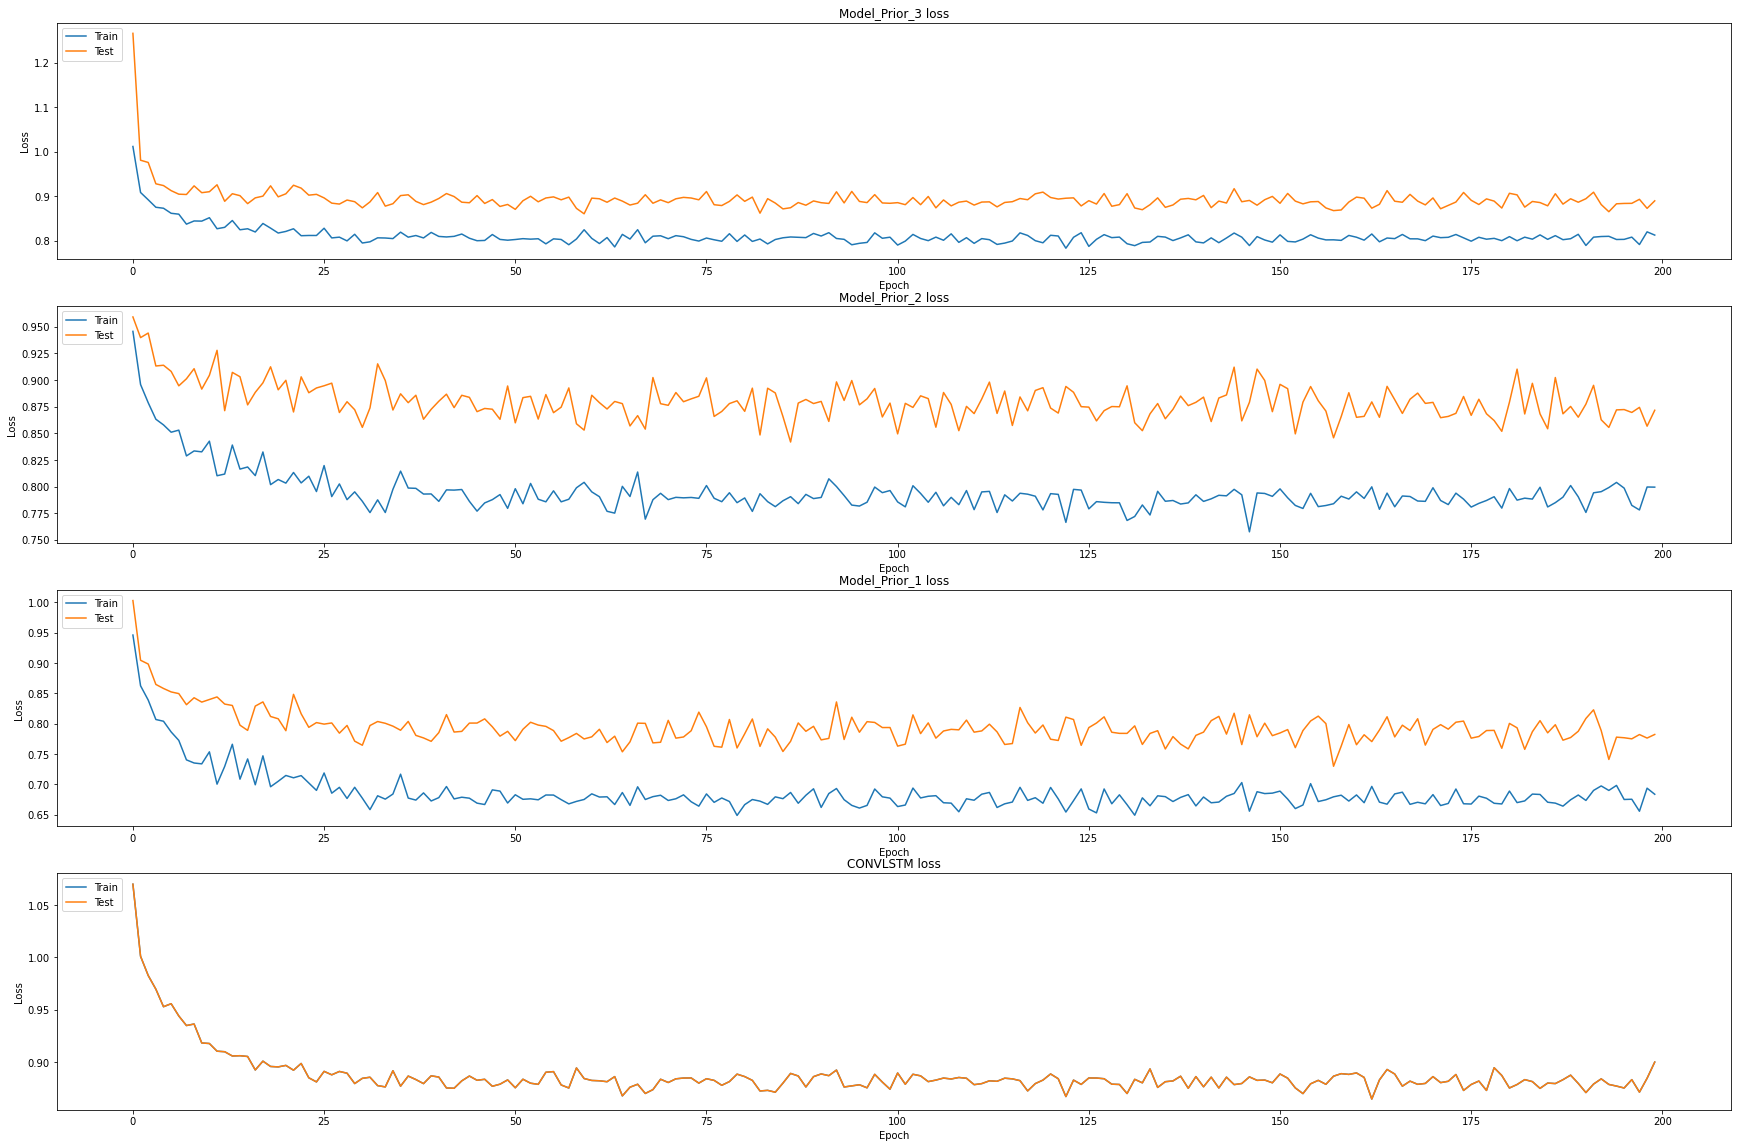

In [18]:
plt.figure(figsize=(30, 20))
plt.subplot(411)
plt.plot(history.history['model_3_loss'])
plt.plot(history.history['val_model_3_loss'])
plt.title('Model_Prior_3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(412)
plt.plot(history.history['model_2_loss'])
plt.plot(history.history['val_model_2_loss'])
plt.title('Model_Prior_2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(413)
plt.plot(history.history['model_1_loss'])
plt.plot(history.history['val_model_1_loss'])
plt.title('Model_Prior_1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(414)
plt.plot(history.history['output_loss'])
plt.plot(history.history['output_loss'])
plt.title('CONVLSTM loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# plt.subplot(311)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')

plt.savefig(HOME_DIR+'/plots/'+'training_loss_IOU_'+MODEL_DESC+'.png')

# Model Evaluation

In [16]:
""" MOdel Evaluation """
from keras.models import load_model
test_dataset = Dataset(PATH_TO_INPUT,
                       status = 'test',
                classes = Defined_CLASSES,
                augmentation = validation_augmentation(),
                preprocessing = get_preprocessing(preprocess_input),
                
    )

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)
loading = True
if (loading== True):
    model.load_weights(PATH_TO_SAVE_MODEL+MODEL_DESC+'.h5')


scores = model.evaluate_generator(test_dataloader)
print('__model_3__:\n')
print("model_3_Loss: {:.5}".format(scores[1]))
print("model_3 mean iou_score: {:.5}".format(scores[5]))
print("model_3 mean f1_score: {:.5}".format(scores[6]))
print("model_3 mean precesion: {:.5}".format(scores[7]))
print("model_3 mean recall: {:.5}".format(scores[8]))
                   
print('__model_2__:\n')                  
print("model_2_Loss: {:.5}".format(scores[2]))                   
print("model_2 mean iou_score: {:.5}".format(scores[9]))
print("model_2 mean f1_score: {:.5}".format(scores[10]))
print("model_2 mean precesion: {:.5}".format(scores[11]))
print("model_2 mean recall: {:.5}".format(scores[12]))

print('__model_1__:\n')
print("model_1_Loss: {:.5}".format(scores[3]))
print("model_1 mean iou_score: {:.5}".format(scores[13]))
print("model_1 mean f1_score: {:.5}".format(scores[14]))
print("model_1 mean precesion: {:.5}".format(scores[15]))
print("model_1 mean recall: {:.5}".format(scores[16]))

print('__CONVLSTM__:\n')
print("Loss: {:.5}".format(scores[4]))
print("mean iou_score: {:.5}".format(scores[17]))
print("mean f1_score: {:.5}".format(scores[18]))
print("mean precesion: {:.5}".format(scores[19]))
print("mean recall: {:.5}".format(scores[20]))


231
77
78
__model_3__:

model_3_Loss: 0.82059
model_3 mean iou_score: 0.18244
model_3 mean f1_score: 0.28445
model_3 mean precesion: 0.34391
model_3 mean recall: 0.4072
__model_2__:

model_2_Loss: 0.8264
model_2 mean iou_score: 0.18544
model_2 mean f1_score: 0.29028
model_2 mean precesion: 0.32381
model_2 mean recall: 0.45448
__model_1__:

model_1_Loss: 0.67269
model_1 mean iou_score: 0.29964
model_1 mean f1_score: 0.42952
model_1 mean precesion: 0.555
model_1 mean recall: 0.51778
__CONVLSTM__:

Loss: 0.91227
mean iou_score: 0.31775
mean f1_score: 0.37848
mean precesion: 0.55554
mean recall: 0.69332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1YBBHAHIC


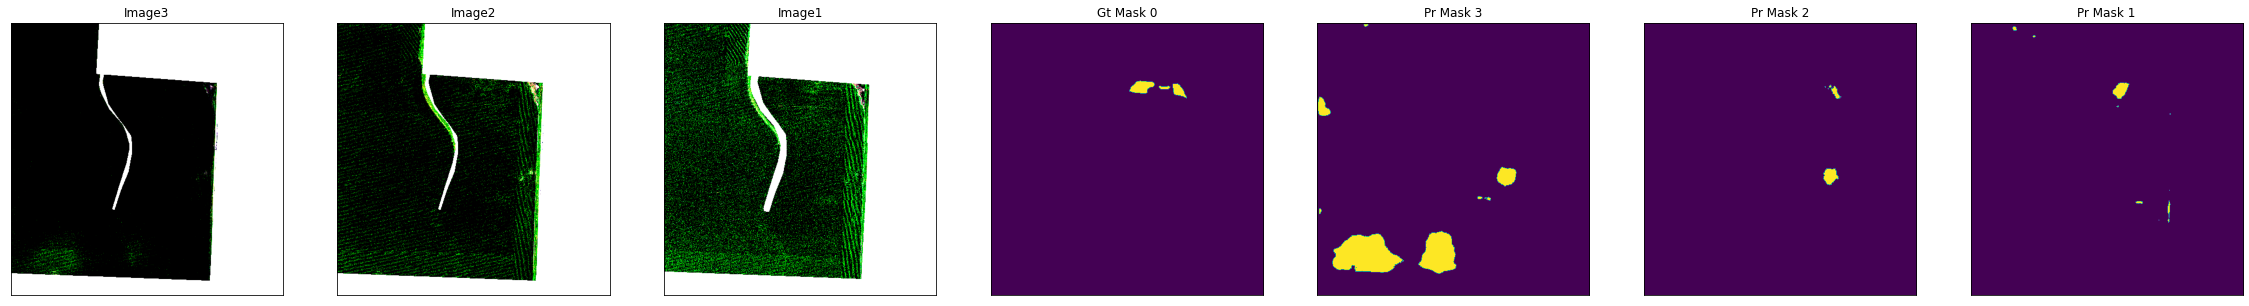

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KRCZYQMUT


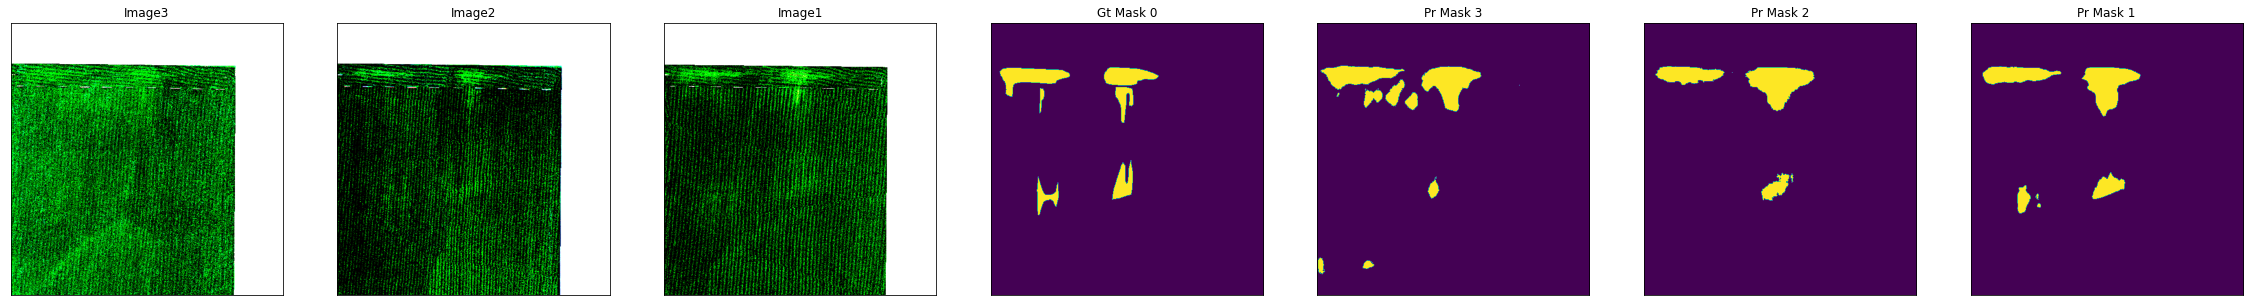

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


P6Z1D4II6


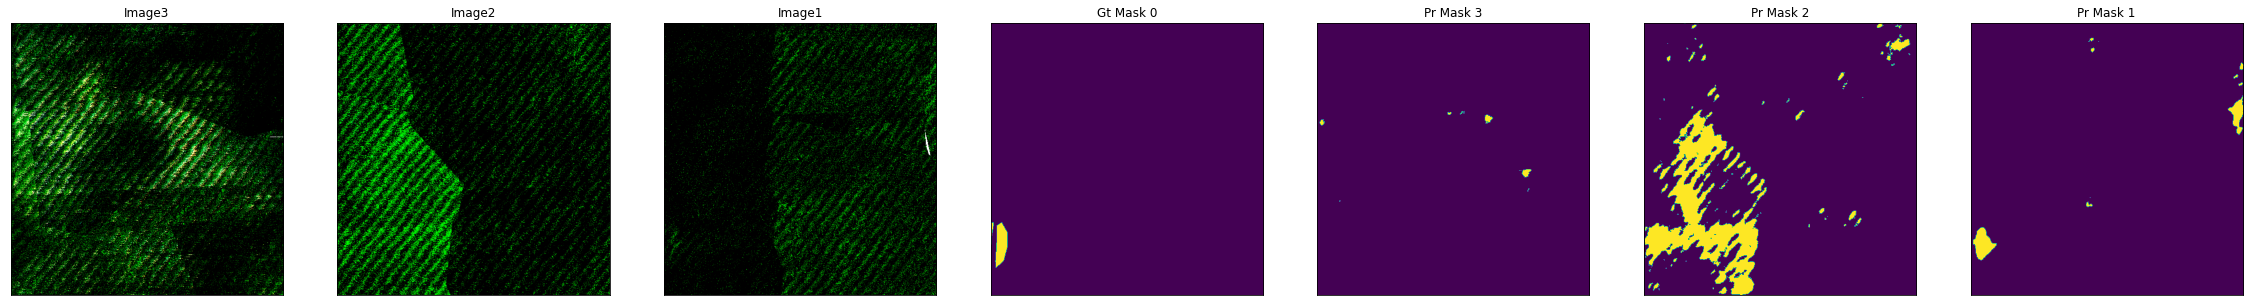

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34VURFGJY


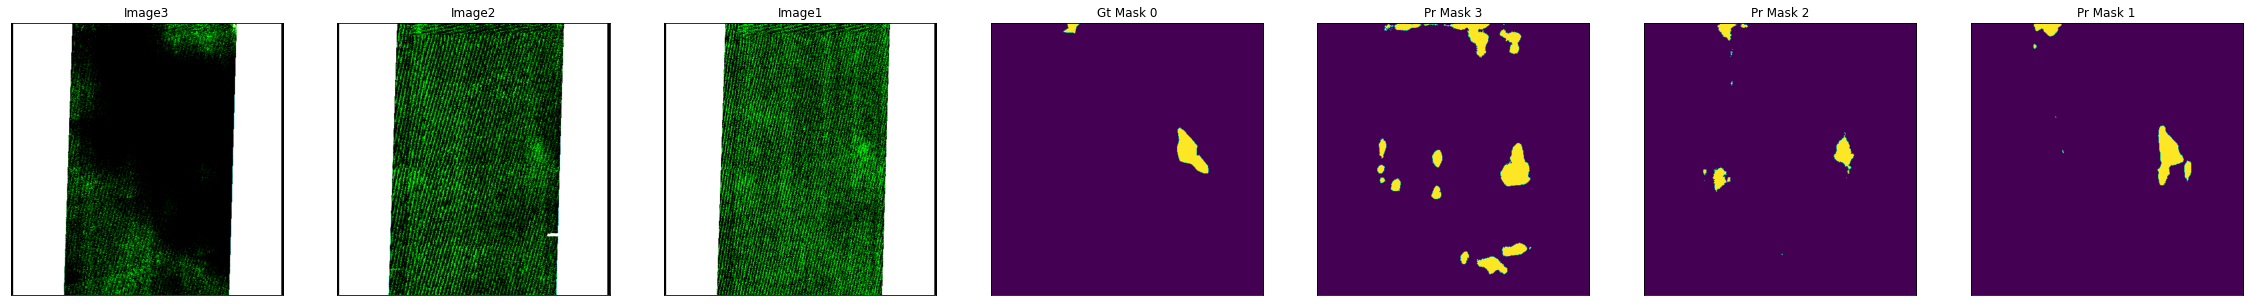

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


W3JYY6WMI


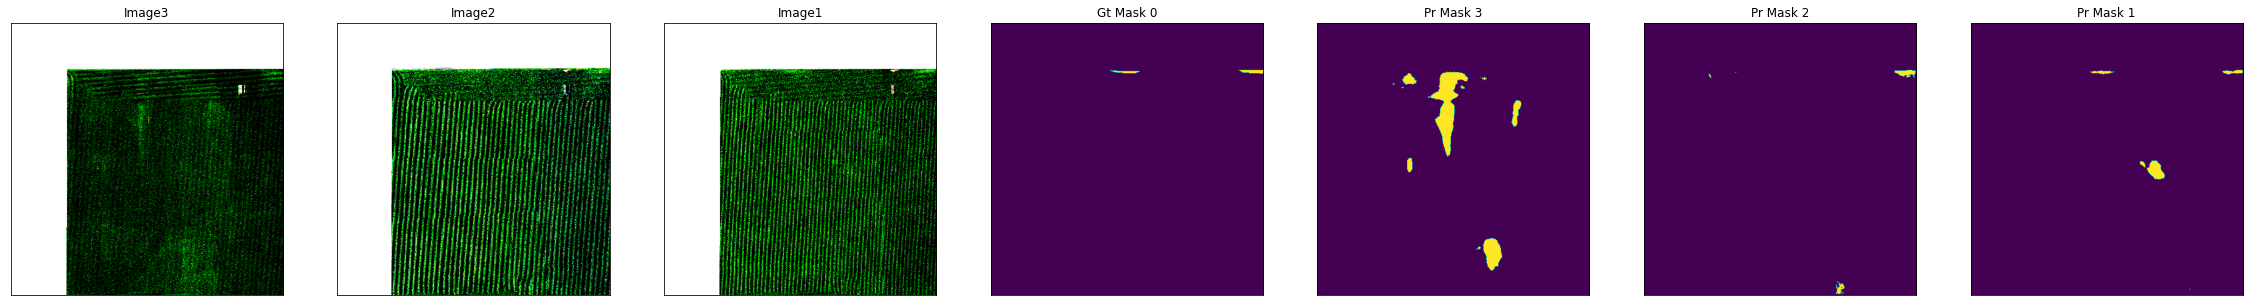

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1GYFAWLYU


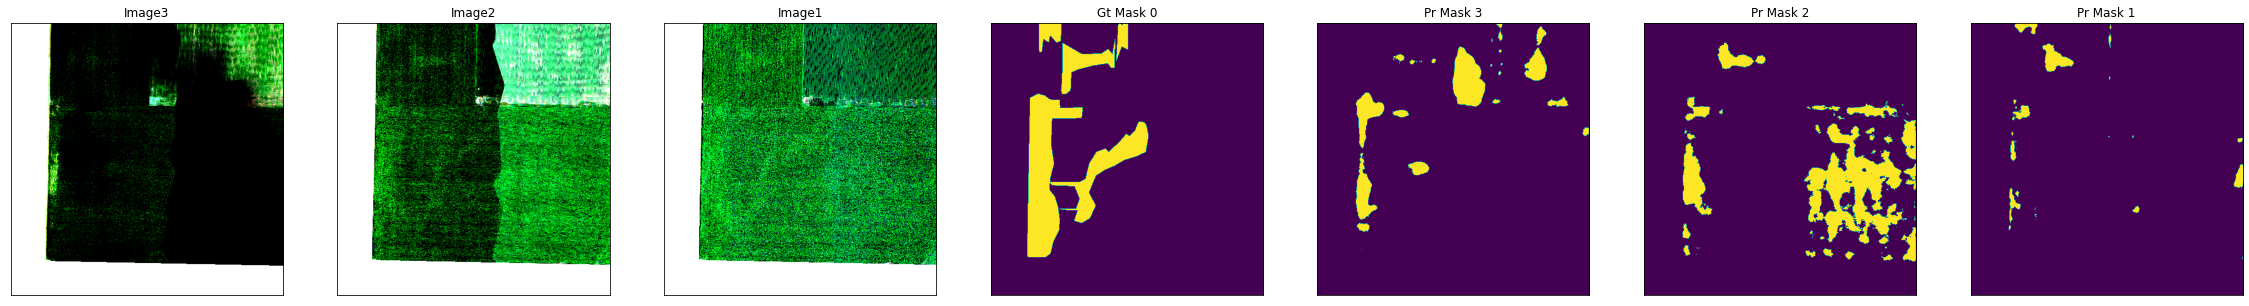

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


P17EGB63M


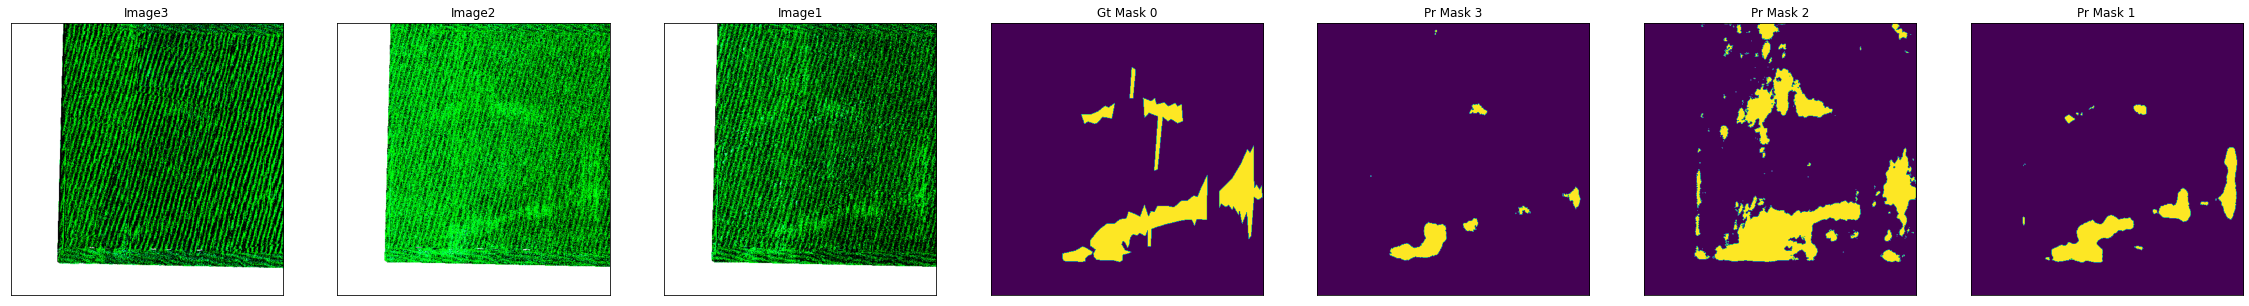

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


WZ2ECYMQT


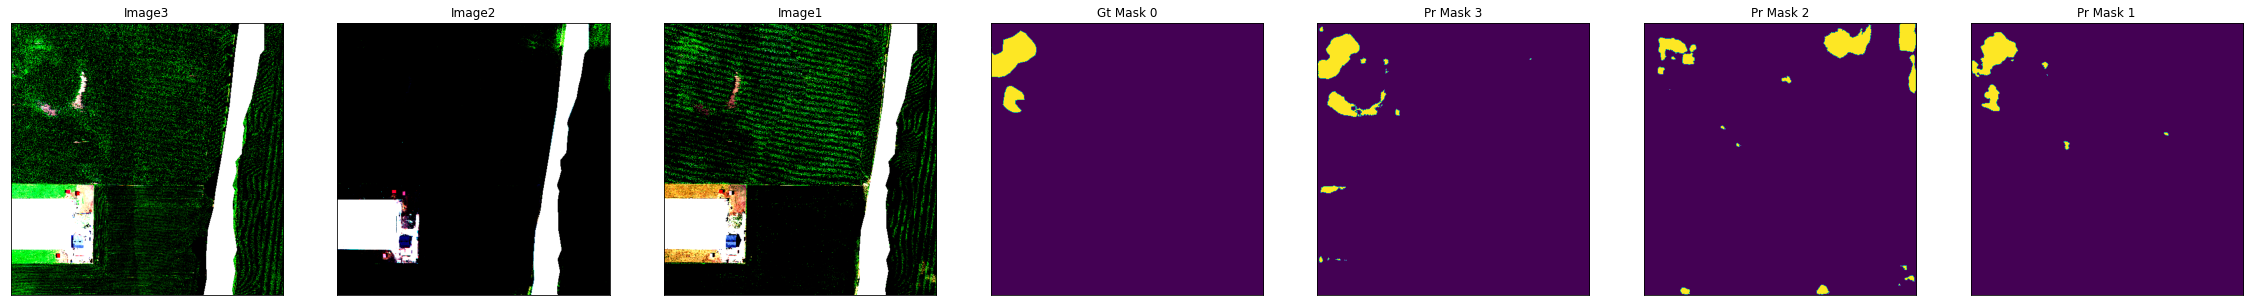

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FJFFLYRLD


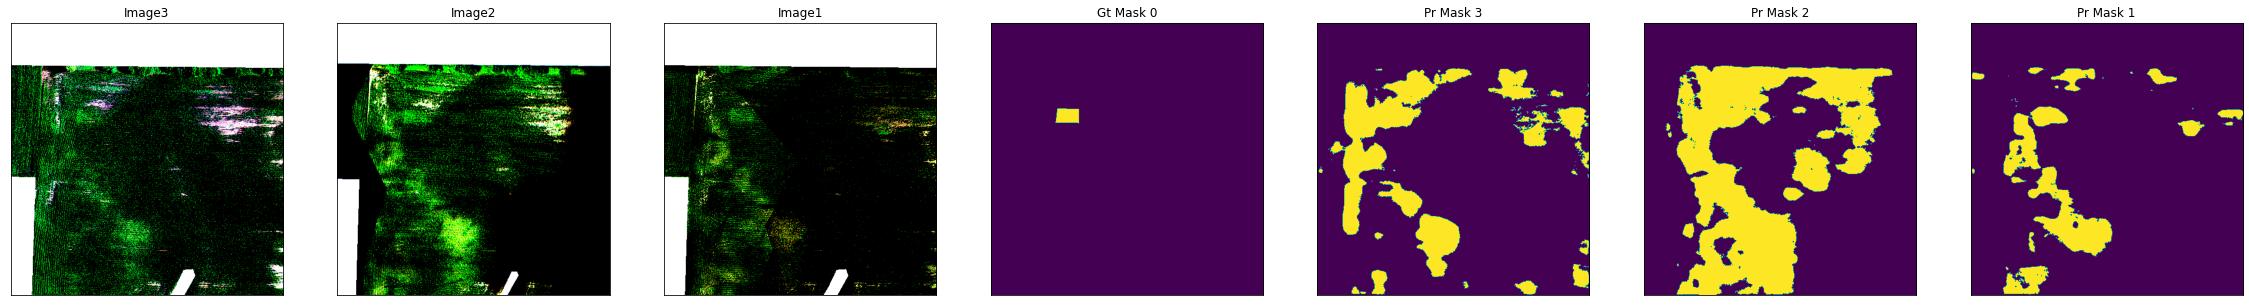

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AMBEDAYEG


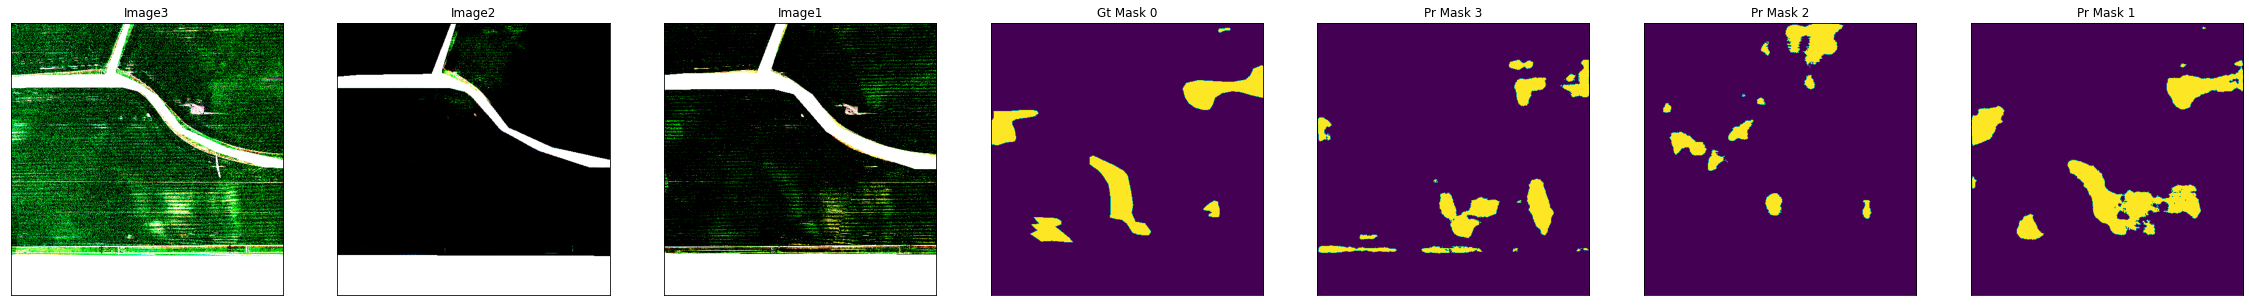

In [19]:
Save_PATH =HOME_DIR+'Dataset/predictions/'+MODEL_DESC+'/'

for i in range(0,10):
    
    image1, image2, image3,gt_mask, boundary_mask,flight_code = test_dataset[i]
    
    if MODEL_NAME == '_Nine_W_1_1_CONV' or MODEL_NAME == '_Nine_WO_1_1_CONV':
        image = np.concatenate((image1, image2, image3), axis = 2)
        image = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image)
        print(flight_code)
        visualize(
            save_status = False,
            save_path = Save_PATH,
            flight_code = flight_code,
            image1 = image1.squeeze(),
            image2 = image2.squeeze(),
            image3 = image3.squeeze(),
            gt_mask_0=gt_mask[...,0].squeeze(),
            pr_mask_0=pr_mask[...,0].squeeze(),
        ) 
    if MODEL_NAME == '_PRE_LSTM':
        combined_image = np.stack((image3, image2, image1), axis = 0)
        combined_image = np.expand_dims(combined_image, axis=0)
        image1 = np.expand_dims(image1, axis=0)
        image2 = np.expand_dims(image2, axis=0)
        image3 = np.expand_dims(image3, axis=0)
        pr_mask3,pr_mask2, pr_mask1, combined_mask = model.predict([image1,image2,image3,combined_image])
        #print(pr_mask.shape)
        pr_mask3 = np.array([(pr_mask3 >= 0.5)])
        pr_mask2 = np.array([(pr_mask2 >= 0.5)])
        pr_mask1 = np.array([(pr_mask1 >= 0.5)])
        print(flight_code)
        visualize(
            save_status = False,
            save_path = Save_PATH,
            flight_code = flight_code,
            image3 = image3.squeeze(),
            image2 = image2.squeeze(),
            image1 = image1.squeeze(),
            gt_mask_0=gt_mask[...,0].squeeze(),
            pr_mask_3=pr_mask3[...].squeeze(),
            pr_mask_2=pr_mask2[...].squeeze(),
            pr_mask_1=pr_mask1[...].squeeze(),
        )
    else:
        image1 = np.expand_dims(image1, axis=0)
        image2 = np.expand_dims(image2, axis=0)
        image3 = np.expand_dims(image3, axis=0)
        pr_mask3,pr_mask2, pr_mask1 = model.predict([image1,image2,image3])
        print(flight_code)
        visualize(
            save_status = False,
            save_path = Save_PATH,
            flight_code = flight_code,
            image1 = image1.squeeze(),
            image2 = image2.squeeze(),
            image3 = image3.squeeze(),
            #image_0=denormalize(image.squeeze()),
            gt_mask_0=gt_mask[...,0].squeeze(),
            pr_mask1=pr_mask1[...,0].squeeze(),
            pr_mask2=pr_mask2[...,0].squeeze(),
            pr_mask3=pr_mask3[...,0].squeeze(),
        ) 

        
